In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [4]:
df = pd.read_csv('../data/weather.csv', index_col=0, parse_dates=True)
df.head()

,t
Day,
2008-01-01,0
2008-01-02,-5
2008-01-03,-11
2008-01-04,-11
2008-01-05,-12


In [5]:
df['month'] = df.index.month
df['year'] = df.index.year
df_monthly = df.groupby(['year', 'month']).mean()

## Задача

Проверить на стационарность двумя критериями последний месяц измерений (по полному датасету)

<AxesSubplot:xlabel='Day'>

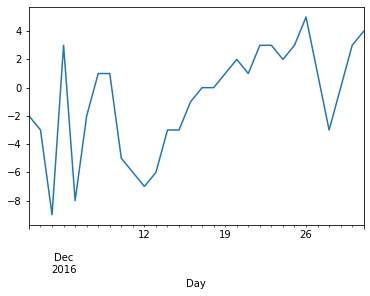

In [6]:
df.t.iloc[-30:].plot()

Возьмем уровень значимости 0.05

In [7]:
alpha = 0.05
stat, p_value, *_ = statsmodels.tsa.stattools.kpss(df.t.iloc[-30:])

if p_value < alpha:
    print('Ряд стационарен')
else:
    print('Ряд нестационарен')

Ряд стационарен


In [8]:
stat, p_value, *_ = statsmodels.tsa.stattools.adfuller(df.t.iloc[-30:])

if p_value < alpha:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


Тесты разошлись во мнениях.

## Задача

Найти оптимальные p, q и d (использовать критерий Акаике).

Разбить данные на треин и тест, посчитать МSЕ или MAE, вывести график, на котором отобразить разными цветами:
- тренировочную выборку
- тестовую выборку
- прогноз

In [9]:
# Если стоит старый statsmodels, то использовать этот импорт:
# from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.arima.model import ARIMA 

In [49]:
p_list = [2, 3, 4]
d_list = [0, 1]
q_list = [0, 1, 2]

from itertools import product

n_sample = len(df_monthly)
pivot = int(0.8 * n_sample)
x_train, x_test = df_monthly.iloc[:pivot], df_monthly.iloc[pivot:]
best_aic = 10000
best_params = (None, None, None)
for p, d, q in product(p_list, d_list, q_list):
    model = ARIMA(x_train, order=(p, d, q)).fit()
    if model.aic < best_aic:
        best_aic = model.aic
        x_pred = model.forecast(len(x_test))
        best_params = (p, d, q)

C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

In [50]:
best_params

(2, 0, 2)

In [10]:
def plot_train_test_pred(train, test, pred):
    t_train = list(range(len(train)))
    t_test = list(range(len(train), len(train) + len(test)))
    plt.plot(t_train, train.values)
    plt.plot(t_test, test.values)
    plt.plot(t_test, pred.values)
    plt.legend(['train', 'test', 'pred'])

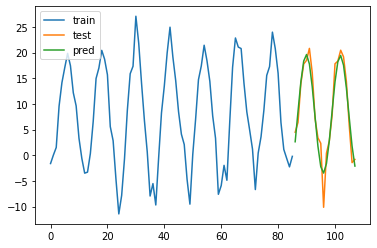

In [53]:
plot_train_test_pred(x_train, x_test, x_pred)

## Задача

К датасету с погодой применить логарифм и спрогнозировать ряд. Сравнить с тем, что было до этого. Не забываем про обратное преобразование.

In [56]:
x_log = np.log(x_train + 100).values
model = ARIMA(x_log, order=(2, 0, 2)).fit()
x_pred_log = model.forecast(len(x_test))
x_pred = pd.Series(np.exp(x_pred_log) - 100)

C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Параметры нужно подбирать заново, чтобы качество стало лучше

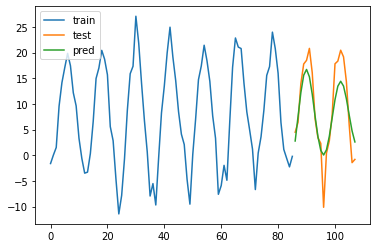

In [57]:
plot_train_test_pred(x_train, x_test, x_pred)

## Задача

К датасету с погодой примернить дифференцирование и спрогнозировать ряд. Сравнить с тем, что было до этого.

Обратное преобразование можно сделать при помощи `np.cumsum()`

In [78]:
first_val = x_train.t.iloc[0]
x_train_diff = x_train.diff().dropna()
model = ARIMA(x_train_diff.values, order=(2, 0, 2)).fit()
x_pred_diff = model.forecast(len(x_test) - 1)
x_pred_diff = np.array([first_val] + x_pred_diff.tolist())
x_pred = pd.Series(np.cumsum(x_pred_diff))

C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


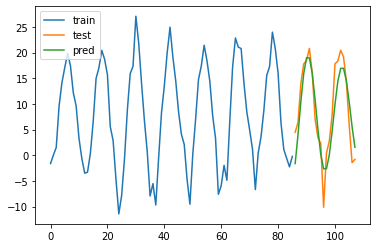

In [79]:
plot_train_test_pred(x_train, x_test, x_pred)

## Задача

Реализовать кросс-валидацию для временного ряда, прогнозируя на один шаг вперед. Оценить точность модели.

In [80]:
test = []
pred = []
for i in range(50, len(df_monthly)):
    train = df_monthly.t.iloc[:i]
    test.append(df_monthly.t.iloc[i])
    model = ARIMA(train, order=(2, 0, 2)).fit()
    pred.append(model.forecast(1).iloc[0])
pred

C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

[-3.411326789968551,
 4.04004802803657,
 12.084490703384455,
 18.663964900229495,
 20.869263719754574,
 20.261700713344027,
 15.565403627271778,
 9.110435530643677,
 2.2641668373917003,
 -2.1892953988691612,
 -6.227648691864454,
 -4.500160551950978,
 1.2139917659239892,
 5.703641931384451,
 13.001935194340408,
 19.70773521478688,
 22.754872831246587,
 20.213053522675843,
 15.063727243325582,
 7.428786076104843,
 0.547310741799965,
 -3.6458707739225646,
 -4.897221065227256,
 -4.7699100841631354,
 0.7391192678205618,
 7.575364358733923,
 13.895471622059116,
 18.718384747107738,
 19.59669473721107,
 19.05640525609924,
 14.732399655675223,
 8.495225957061296,
 1.2719847168076903,
 -3.6510452321526436,
 -4.706411753442108,
 -2.4607134455050836,
 2.6284569590394025,
 9.114141024114309,
 13.928046480181465,
 17.950398933586932,
 19.24405442055029,
 17.36256122876557,
 14.111925279381943,
 8.84470407509109,
 2.411033705538827,
 -1.801927236264497,
 -2.579279579930038,
 -3.302071686602268,
 1.6

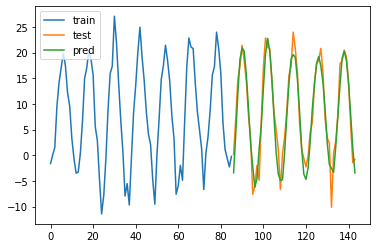

In [85]:
plot_train_test_pred(x_train, pd.Series(test), pd.Series(pred))

In [87]:
r2_score(test, pred)

0.9088896624502949


## Задача

Применить `RandomForestRegressor` к датасету с погодой. Подобрать гиперпараметры. Применить кросс-валидацию, сравнить с ARIMA.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

Для начала сформируем датасет. Лес должен обучаться на последних $k$ значениях

In [35]:
k = 5
X = []
Y = []
for i in range(len(df) - k):
    X.append(df['t'].iloc[i:i+k])
    Y.append(df['t'].iloc[i+k])
X = np.array(X)
Y = np.array(Y)

Подберем гиперпараметры по всей выборке

In [44]:
params = {
    'n_estimators': [50, 100, 150, 500],
    'max_depth': [3, 4, 5],
    'bootstrap': [True, False]
}
search = RandomizedSearchCV(RandomForestRegressor(), params, scoring='r2')
search.fit(X, Y)
search.best_estimator_

RandomForestRegressor(max_depth=5, n_estimators=150)

Проведем кросс-валидацию и построим графики

In [49]:
%%time
train_end = 3000
pred = []
for i in range(train_end, len(X)):
    model = RandomForestRegressor(max_depth=5, n_estimators=150)
    model.fit(X[:i], Y[:i])
    pred_ = model.predict([X[i]])
    pred.append(pred_)
pred = np.array(pred).ravel()

Wall time: 1min 49s


$R^2$ очень даже неплохой

In [50]:
r2_score(Y[train_end:], pred)

0.867408285224855

Сравним с наивным решением (прогнозируем последним известным значением)

Наша модель немного лучше работает

In [54]:
r2_score(Y[train_end + 1:], Y[train_end:-1])

0.8517045789380635

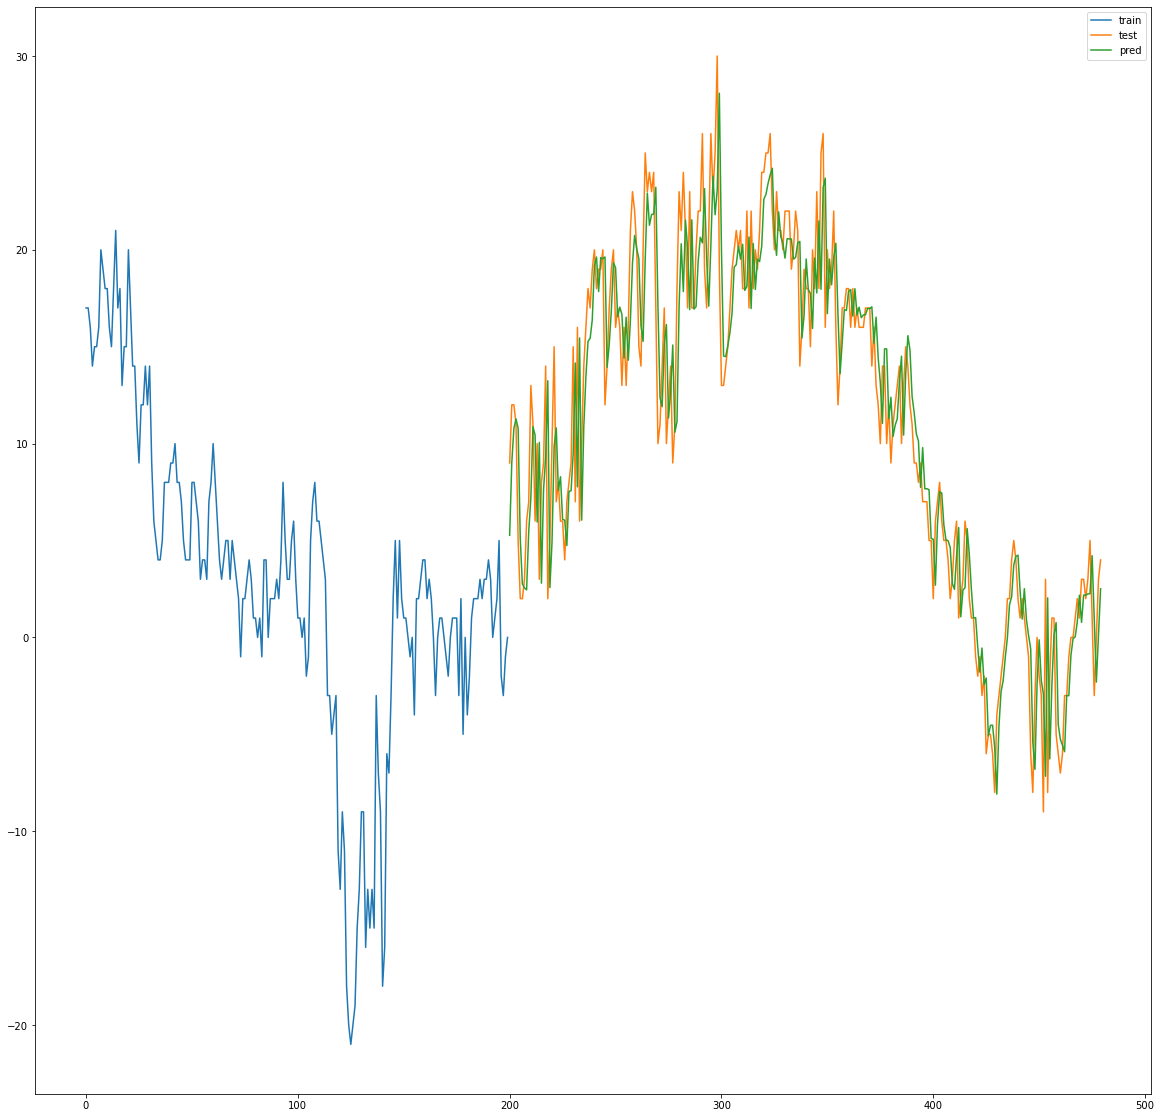

In [51]:
train_series = df['t'].iloc[train_end-200:train_end]
test_series = pd.Series(Y[train_end:])
pred_series = pd.Series(pred)
plt.figure(figsize=(20, 20))
plot_train_test_pred(train_series, test_series, pred_series)

Остатки, похоже, распределены нормально. 

<AxesSubplot:>

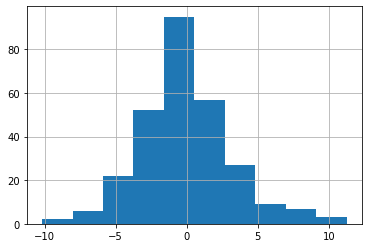

In [52]:
(pred_series - test_series).hist()

## Задача

Применить функцию `fourierExtrapolation` к исходному ряду `df['t']`

In [148]:
from numpy import fft
    
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    
    # В этой строчке добавляем list()
    # indexes = range(n)
    indexes = list(range(n))
    
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

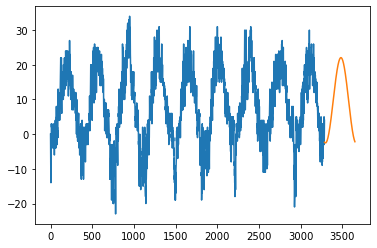

In [151]:
n_pred = 365
pred = fourierExtrapolation(df['t'], n_pred)[-n_pred:]

t = list(range(len(df['t'])))
t_pred = list(range(len(t), len(t) + n_pred))

plt.plot(t, df['t'].values)
plt.plot(t_pred, pred)

Если взять другое количество n_harm, то получится более зашумленая кривая.